# 0 数据增强

In [12]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
import random


# 下载nltk需要的数据
# nltk.download('wordnet')
# nltk.download('omw-1.4')


def get_synonyms(word):
    """获取单词的同义词列表"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.name().lower() != word.lower():
                synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)


def synonym_replacement(sentence):
    """通过同义词替换来增强句子"""
    words = sentence.split()
    new_words = words.copy()
    for i, word in enumerate(words):
        synonyms = get_synonyms(word)
        if synonyms:
            new_words[i] = random.choice(synonyms)
    return ' '.join(new_words)


def random_deletion(sentence, p=0.2):
    """通过随机删除单词来增强句子"""
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.random() > p]
    if not new_words:  # 确保至少保留一个单词
        new_words.append(random.choice(words))
    return ' '.join(new_words)


# 读取原始数据
df = pd.read_csv("./data/query_decider.csv", encoding='utf-8', sep='|')

# 增强数据集
augmented_data = []
for index, row in df.iterrows():
    original_sentence = row['text']
    label = row['label']

    # 同义词替换增强
    augmented_sentence_synonym = synonym_replacement(original_sentence)
    augmented_data.append([augmented_sentence_synonym, label])

    # 随机删除单词增强
    augmented_sentence_deletion = random_deletion(original_sentence)
    augmented_data.append([augmented_sentence_deletion, label])

# 将增强的数据添加到原始数据框中
augmented_df = pd.DataFrame(augmented_data, columns=['text', 'label'])
final_df = pd.concat([df, augmented_df]).drop_duplicates().reset_index(drop=True)

# 保存增强后的数据集
final_df.to_csv("./data/enhanced_query_decider.csv", index=False)

# 1 数据预处理

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# 读取数据
df = pd.read_csv("./data/query_decider.csv", sep='|')
# 数据扩张，再增强
df = pd.concat([
    df,
    df.sample(frac=0.5, replace=True)
])
# 分割数据集
train_data, test_data = train_test_split(df, test_size=0.2)
print(train_data.shape, test_data.shape)

(941, 2) (236, 2)


# 2 模型训练

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /root/lanyun-tmp/hf/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/941 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

/root/miniconda/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.564333,0.631356
2,No log,0.436235,0.788136
3,No log,0.370676,0.851695
4,No log,0.296821,0.881356
5,No log,0.248913,0.919492
6,No log,0.206591,0.919492
7,No log,0.172646,0.949153
8,No log,0.148244,0.961864
9,No log,0.129864,0.966102
10,No log,0.122976,0.961864


/root/miniconda/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/root/miniconda/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/root/miniconda/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/root/miniconda/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/root/miniconda/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70:

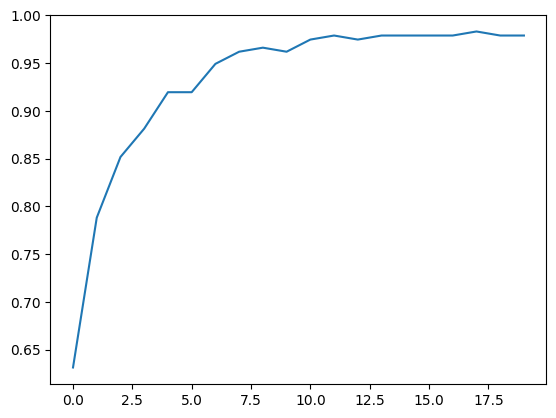

In [6]:

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "/root/lanyun-tmp/hf/bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    local_files_only=True
)
model.to(device)


def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256
    )


train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accs = []


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = np.mean(predictions == labels)
    accs.append(acc)
    return {"accuracy": acc}


# 修改训练参数
args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=20,
    learning_rate=3e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=2,
    eval_strategy="epoch",
    save_strategy="best",
    load_best_model_at_end=True,
)

# 创建Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 开始训练
trainer.train()

import matplotlib.pyplot as plt

plt.plot(accs)
plt.show()

# 3 测试

In [1]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
)
import torch

checkpoint = "./results/train_query_decider_acc_98"
# model_name = "google-bert/bert-base-multilingual-cased"
model_name = "/root/lanyun-tmp/hf/bert-base-multilingual-cased"
model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2
)
tokenizer = BertTokenizer.from_pretrained(
    model_name,
    local_files_only=True
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
text = "你好啊."
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
outputs = model(input_ids)
print(torch.argmax(outputs.logits))

tensor(0, device='cuda:0')


In [2]:
integrated_save_path = "./results/query_decider_acc_98"
model.save_pretrained(integrated_save_path)
tokenizer.save_pretrained(integrated_save_path)

('./results/my_integrated_model/tokenizer_config.json',
 './results/my_integrated_model/special_tokens_map.json',
 './results/my_integrated_model/vocab.txt',
 './results/my_integrated_model/added_tokens.json')